Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Загружено: best_model.pkl
Генерация производных молекул...
Всего сгенерировано: 562/1000
Не достигнута цель. Продолжаем генерацию...
Всего сгенерировано: 1000/1000
Успешно сгенерировано 1000 молекул!

Итого молекул: 1011
Из них сгенерированных: 1000

Результаты сохранены в файл: generated_molecules.csv

Статистика генерации:
- Уникальных SMILES: 833
- Успешный процент генерации: 100.0%
Предсказаны значения pValue
Активных соединений (pValue>6): 245
Найдено перспективных хитов: 6


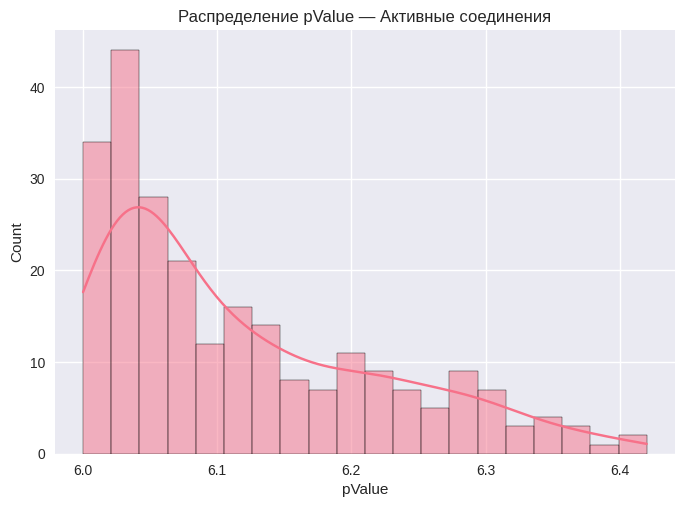

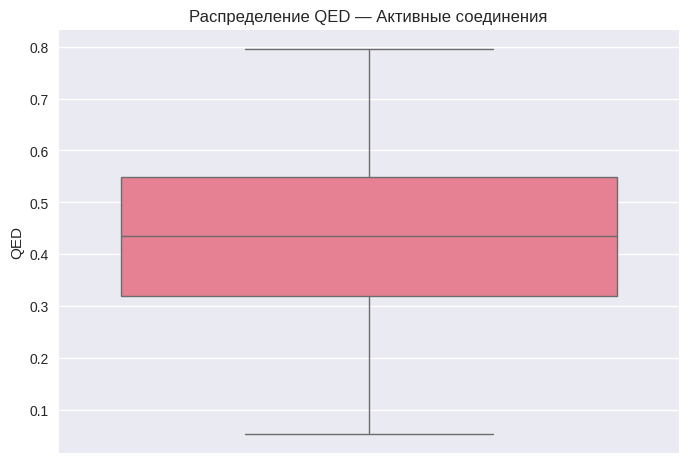

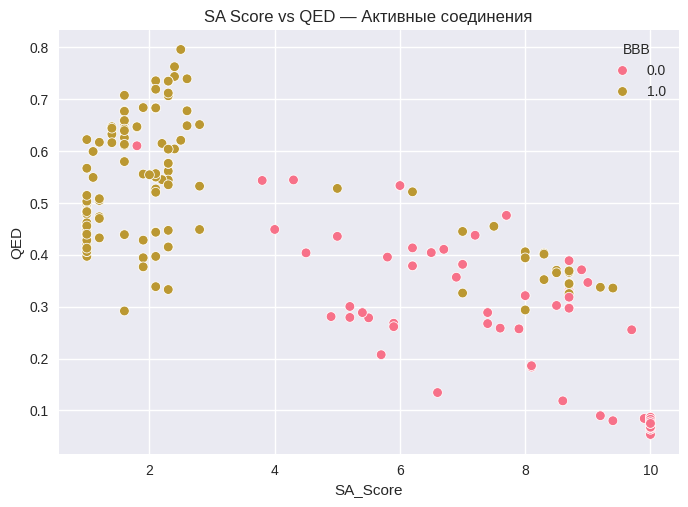

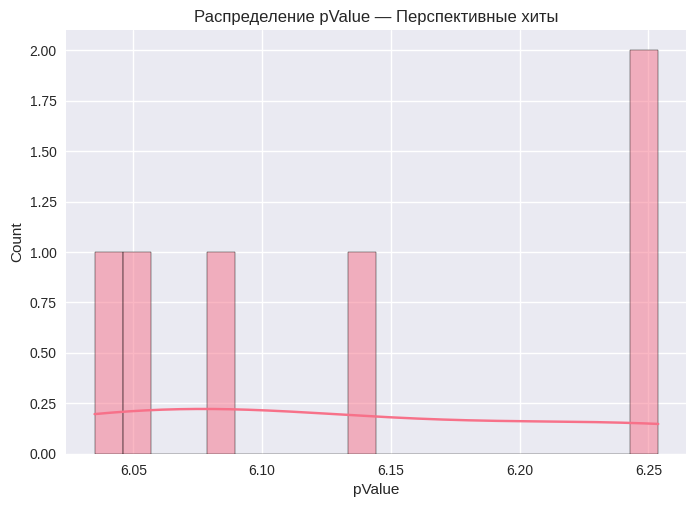

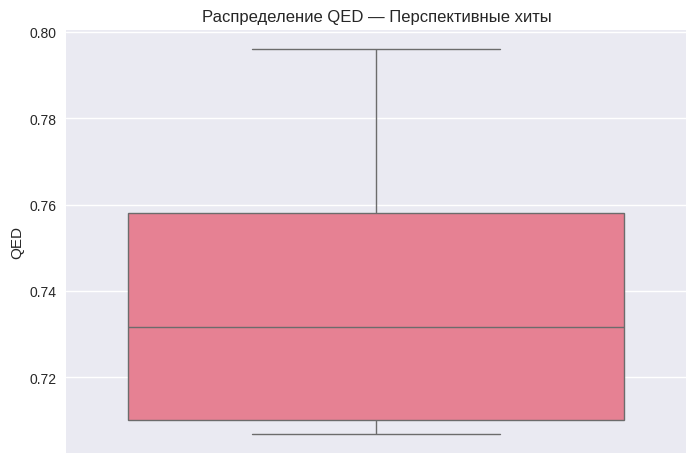

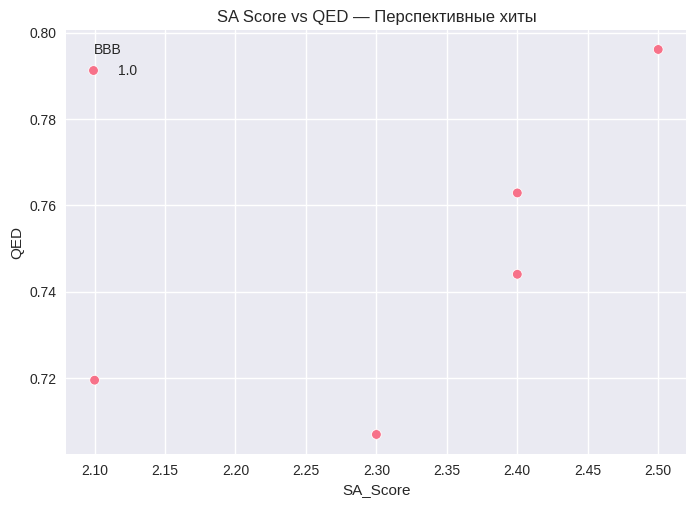

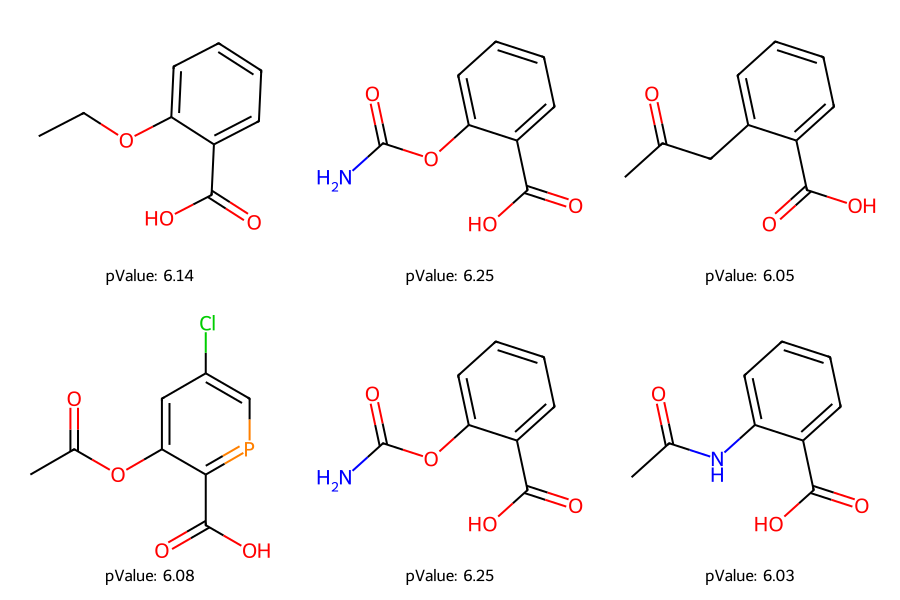

CSV-файлы сохранены (selected_hits.csv, all_active_molecules.csv)


In [77]:
# =========================================================
# 0. Установка зависимостей (один раз в Colab)
# =========================================================
!pip install rdkit molvs numpy pandas scikit-learn xgboost matplotlib seaborn
# =========================================================
# 1. Импорты и настройки
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import os

warnings.filterwarnings('ignore')

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, QED, Crippen, rdMolDescriptors, Draw
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.base import BaseEstimator, RegressorMixin
from google.colab import drive

plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

# =========================================================
# 2. Инициализация BRENK-фильтра
# =========================================================
brenk_params = FilterCatalogParams()
brenk_params.AddCatalog(FilterCatalogParams.FilterCatalogs.BRENK)
brenk_catalog = FilterCatalog(brenk_params)

def check_brenk(mol):
    return 1 if brenk_catalog.HasMatch(mol) else 0  # 1 = содержит нежелательную подструктуру

# =========================================================
# 3. Функции для расчета свойств
# =========================================================
def calc_sa_score(mol):
    """Упрощенный SA Score: 1 (легкий) ... 10 (сложный)"""
    try:
        rot = rdMolDescriptors.CalcNumRotatableBonds(mol)
        rings = rdMolDescriptors.CalcNumRings(mol)
        hetero = sum(1 for a in mol.GetAtoms() if a.GetAtomicNum() not in [1, 6])
        score = 0.5 * rot + 0.3 * rings + 0.2 * hetero
        return min(max(score, 1), 10)
    except:
        return None

def predict_bbb(mol):
    mw = Descriptors.MolWt(mol)
    logp = Crippen.MolLogP(mol)
    donors = Lipinski.NumHDonors(mol)
    psa = Descriptors.TPSA(mol)
    return 0 if (mw > 500 or logp > 5 or donors > 3 or psa > 120) else 1

def contains_toxicophore(mol):
    return 1 if brenk_catalog.HasMatch(mol) else 0

def lipinski_violations(mol):
    v = 0
    if Descriptors.MolWt(mol) > 500: v += 1
    if Crippen.MolLogP(mol) > 5: v += 1
    if Lipinski.NumHDonors(mol) > 5: v += 1
    if Lipinski.NumHAcceptors(mol) > 10: v += 1
    return v

# =========================================================
# 4. Загрузка модели и списка дескрипторов
# =========================================================
drive.mount('/content/drive')  # авторизация
MODEL_PATH = '/content/drive/MyDrive/best_model.pkl'
FEATS_PATH = '/content/drive/MyDrive/feature_importance.csv'  # колонка 'Feature'

def load_pickle(path):
    try:
        with open(path, 'rb') as f:
            obj = pickle.load(f)
        print(f"Загружено: {os.path.basename(path)}")
        return obj
    except Exception as e:
        print(f"Ошибка загрузки {path}: {e}")
        return None

model = load_pickle(MODEL_PATH)
required_features = pd.read_csv(FEATS_PATH)['Feature'].tolist()

# Запасная модель
if model is None:
    class DummyPredictor(BaseEstimator, RegressorMixin):
        def predict(self, X):  # X = ndarray
            np.random.seed(0)
            return np.random.uniform(5, 8, size=len(X))
    model = DummyPredictor()

# =========================================================
# 5. Подготовка списка SMILES
# =========================================================
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit import RDLogger
import random
RDLogger.DisableLog('rdApp.*')  # Отключаем предупреждения RDKit

# Оригинальные молекулы
smiles_list = [
    "CC(=O)OC1=CC=CC=C1C(=O)O",      # аспирин
    "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",  # кофеин
    "C1CCCCC1",                      # циклогексан
    "C1=CC=CC=C1",                   # бензол
    "CCO",                           # этанол
    "CN(C)C=O",                      # ДМФА
    "C1CCCCC1O",                     # циклогексанол
    # молекулы из chembl.csv
    "Oc1ccc2c(c1)CCC(c1ccccc1)N2Cc1ccc(OCCN2CCCCC2)cc1",
    "Oc1cccc(C2CCc3cc(O)ccc3N2Cc2ccc(OCCN3CCCCC3)cc2)c1",
    "CCN(CCCc1ccc(Cl)cc1)c1nc(NCCc2ccc(O)cc2)nc(N2CCNCC2)n1",
    "Oc1ccc(-c2nn3c(C(F)(F)F)cc(C(F)(F)F)nc3c2-c2ccc(OCCN3CCCCC3)cc2)cc1",
    "Oc1ccc(-c2ccc3cc(O)ccc3c2Oc2ccc(OCCN3CCCCC3)cc2)cc1"
    # скаффолды - вкусовщина
    "C1CCNC1"
    "c2ccc1NCCc1c2"
    "C2CCC1CNCC1C2"
    "c2ccc1NCCCc1c2"

]

# Улучшенная функция генерации производных с гарантированным результатом
def generate_derivatives(smiles, target_count=100, max_tries=500):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return []

    derivatives = set()
    valid_atoms = [6, 7, 8, 9, 15, 16, 17]  # C, N, O, F, P, S, Cl
    operations = ['add_atom', 'change_atom', 'add_ring', 'remove_atom', 'mutate_bond']

    tries = 0
    while len(derivatives) < target_count and tries < max_tries:
        tries += 1
        try:
            new_mol = Chem.RWMol(mol)

            # Применяем несколько случайных операций для увеличения разнообразия
            for _ in range(random.randint(1, 3)):
                operation = random.choice(operations)

                if operation == 'add_atom' and new_mol.GetNumAtoms() < 30:
                    new_atom_idx = new_mol.AddAtom(Chem.Atom(random.choice(valid_atoms)))
                    if new_mol.GetNumAtoms() > 1:
                        existing_atom = random.randint(0, new_mol.GetNumAtoms()-2)
                        new_mol.AddBond(existing_atom, new_atom_idx, random.choice([
                            Chem.BondType.SINGLE,
                            Chem.BondType.DOUBLE
                        ]))

                elif operation == 'change_atom' and new_mol.GetNumAtoms() > 0:
                    atom_idx = random.randint(0, new_mol.GetNumAtoms()-1)
                    new_mol.GetAtomWithIdx(atom_idx).SetAtomicNum(random.choice(valid_atoms))

                elif operation == 'add_ring' and new_mol.GetNumAtoms() >= 5:
                    ring_size = random.choice([5, 6])
                    atoms = random.sample(range(new_mol.GetNumAtoms()), min(ring_size, new_mol.GetNumAtoms()))
                    for i in range(len(atoms)):
                        new_mol.AddBond(atoms[i], atoms[(i+1)%len(atoms)], Chem.BondType.SINGLE)

                elif operation == 'remove_atom' and new_mol.GetNumAtoms() > 5:
                    atom_idx = random.randint(0, new_mol.GetNumAtoms()-1)
                    new_mol.RemoveAtom(atom_idx)

                elif operation == 'mutate_bond' and new_mol.GetNumBonds() > 0:
                    bond = random.choice(list(new_mol.GetBonds()))
                    bond.SetBondType(random.choice([
                        Chem.BondType.SINGLE,
                        Chem.BondType.DOUBLE,
                        Chem.BondType.TRIPLE
                    ]))

            # Санитизация и проверка валидности
            Chem.SanitizeMol(new_mol)
            new_smiles = Chem.MolToSmiles(new_mol)

            if new_smiles and new_smiles != smiles:
                derivatives.add(new_smiles)

        except:
            continue

    return list(derivatives)

# Генерируем производные до достижения 1000 молекул
print("Генерация производных молекул...")
generated_smiles = []
target_total = 1000
batch_size = 50

while len(generated_smiles) < target_total:
    for i, smiles in enumerate(smiles_list):
        needed = target_total - len(generated_smiles)
        if needed <= 0:
            break

        # Генерируем партию молекул
        to_generate = min(batch_size, needed)
        generated = generate_derivatives(smiles, target_count=to_generate)
        generated_smiles.extend(generated)

        print(f"Всего сгенерировано: {len(generated_smiles)}/{target_total}", end='\r')

    if len(generated_smiles) >= target_total:
        break

    # Если не достигли цели, пробуем еще раз
    print(f"\nНе достигнута цель. Продолжаем генерацию...")

print(f"\nУспешно сгенерировано {len(generated_smiles)} молекул!")

# Объединяем все SMILES
all_smiles = smiles_list + generated_smiles

# Создаем DataFrame
df = pd.DataFrame({'SMILES': all_smiles})
df['mol'] = df['SMILES'].apply(Chem.MolFromSmiles)
df = df[df['mol'].notna()].copy()
print(f"\nИтого молекул: {len(df)}")
print(f"Из них сгенерированных: {len(generated_smiles)}")

# Добавляем флаг для сгенерированных молекул
df['is_generated'] = False
df.loc[df.index >= len(smiles_list), 'is_generated'] = True

# Сохраняем результаты
output_file = "generated_molecules.csv"
df.to_csv(output_file, index=False)
print(f"\nРезультаты сохранены в файл: {output_file}")

# Покажем статистику
print("\nСтатистика генерации:")
print(f"- Уникальных SMILES: {len(set(all_smiles))}")
print(f"- Успешный процент генерации: {len(generated_smiles)/(target_total)*100:.1f}%")

# =========================================================
# 6. Вычисление дескрипторов для модели
# =========================================================
def calc_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    calc = MoleculeDescriptors.MolecularDescriptorCalculator(required_features)
    return calc.CalcDescriptors(mol)

df['descriptors'] = df['SMILES'].apply(calc_descriptors)
X = np.array(df['descriptors'].tolist())
df['pValue'] = model.predict(X)
print("Предсказаны значения pValue")

# =========================================================
# 7. Расчет всех свойств
# =========================================================
def full_props(row):
    mol = row['mol']
    return pd.Series({
        'QED': QED.qed(mol),
        'SA_Score': calc_sa_score(mol),
        'BBB': predict_bbb(mol),
        'Toxicophore': contains_toxicophore(mol),
        'BRENK': check_brenk(mol),
        'Lipinski_violations': lipinski_violations(mol)
    })

df = pd.concat([df, df.apply(full_props, axis=1)], axis=1)

# =========================================================
# 8. Фильтрация активных соединений и хитов
# =========================================================
active_df = df[df['pValue'] > 6.0].copy()
print(f"Активных соединений (pValue>6): {len(active_df)}")

hits_df = active_df[
    (active_df['QED'] > 0.7) &                # можно 0.5 при необходимости
    (active_df['SA_Score'].between(2, 6)) &
    (active_df['BBB'] == 1) &
    (active_df['Toxicophore'] == 0) &
    (active_df['BRENK'] == 0) &
    (active_df['Lipinski_violations'] <= 1)
].copy()

def comment(row):
    comments = []
    if row['pValue'] > 7: comments.append("Высокая активность")
    if row['QED'] > 0.8: comments.append("Отличный drug-likeness")
    if row['SA_Score'] < 3: comments.append("Легко синтезируем")
    if row['BBB'] == 1: comments.append("Проходит ГЭБ")
    if row['Lipinski_violations'] == 0: comments.append("0 нарушений Липинского")
    return "; ".join(comments) if comments else "Перспективный кандидат"

hits_df['Comment'] = hits_df.apply(comment, axis=1)
print(f"Найдено перспективных хитов: {len(hits_df)}")

# =========================================================
# 9. Визуализация результатов
# =========================================================
def visualize(df, title):
    if df.empty:
        print("Нет данных для визуализации")
        return

    sns.histplot(df['pValue'], bins=20, kde=True)
    plt.title(f'Распределение pValue — {title}')
    plt.show()

    sns.boxplot(y=df['QED'])
    plt.title(f'Распределение QED — {title}')
    plt.show()

    sns.scatterplot(data=df, x='SA_Score', y='QED', hue='BBB')
    plt.title(f'SA Score vs QED — {title}')
    plt.show()

visualize(active_df, "Активные соединения")
if not hits_df.empty:
    visualize(hits_df, "Перспективные хиты")

# Отображение структур хитов
if not hits_df.empty:
    mols = [Chem.MolFromSmiles(s) for s in hits_df['SMILES']]
    legends = [f"pValue: {p:.2f}" for p in hits_df['pValue']]
    display(Draw.MolsToGridImage(mols, molsPerRow=3, legends=legends, subImgSize=(300,300)))

# =========================================================
# 10. Сохранение результатов
# =========================================================
active_df.drop(columns=['mol','descriptors']).to_csv('all_active_molecules.csv', index=False)
if not hits_df.empty:
    hits_df.drop(columns=['mol','descriptors']).to_csv('selected_hits.csv', index=False)
    print("CSV-файлы сохранены (selected_hits.csv, all_active_molecules.csv)")
else:
    print("Хитов не найдено - CSV не создан")